In [ ]:
!pip install pyweatherbit

In [ ]:
import requests
from datetime import datetime, timedelta
import time
import json
from copy import deepcopy
import pandas as pd
import numpy as np
from weatherbit.api import Api
import matplotlib.pyplot as plt
import seaborn as sns

**Fetch the weather data**

We have used Weatherbit API to collect hourly weather data for the the 6 given monitoring stations in Skopje. The weather data refers to the period from January 1, 2019 to January 15, 2021. It includes information about temperature, pressure, wind speed, precipitation, humidity etc. In order to use it, you need to register at Weatherbit and get an API KEY to access it.

In [ ]:
API_KEY = "API_KEY"
start_date = datetime(2019, 1, 1)
end_date = datetime(2021, 1, 15)
period = timedelta(days=1)
sleep_time = 1
stations = {'Karpos': (42.00666664, 21.38694446),
            'Centar': (41.99249998, 21.4236110),
            'GaziBaba': (42.00258, 21.45134),
            'Lisice': (41.9783, 21.47),
            'Rektorat': (41.9992, 21.4408),
            'Miladinovci': (41.9875, 21.6525)
}

In [ ]:
api = Api(API_KEY)

for station, (latitude, longitude) in stations.items():
  curr_date = deepcopy(start_date)
  f = open(f'./weather_raw_data/{station}.csv', 'a')
  while curr_date <= end_date:
    try:     
      time.sleep(0.2)
      start = curr_date.strftime("%Y-%m-%d")
      curr_date += period
      end = curr_date.strftime("%Y-%m-%d")
      print(start, station)

      # Get hourly history by lat/lon
      api.set_granularity('hourly')
      history = api.get_history(lat=latitude, lon=longitude, start_date=start, end_date=end)
      data = history.json['data']
      for item in data:
        f.write(f'{item}\n')
        f.flush()
    
    except Exception as e:
      time.sleep(sleep_time)

  f.close()

**Format the weather data**

In [ ]:
features = ['rh', 'wind_spd', 'timestamp_utc', 'vis', 'slp', 'pod', 'dni', 
            'elev_angle', 'pres', 'h_angle', 'dewpt', 'snow', 'uv', 'solar_rad',
            'wind_dir', 'ghi', 'dhi', 'app_temp', 'azimuth', 'temp', 'precip', 'clouds']

In [ ]:
for station in stations:
  data = {}
  with open(f'./weather_raw_data/{station}.csv', 'r') as f:
    for line in f:
      line = line.replace('\'', '\"')
      line = line.replace('None', 'null')
      item = json.loads(line)
      timestamp = item['timestamp_utc'][:10] + ' ' + item['timestamp_utc'][11:]
      data[timestamp] = [item[feature] if feature in item else np.nan for feature in features]
  
  df = pd.DataFrame.from_dict(data, orient='index', columns=features)
  df.to_csv(f'./weather_data/{station}.csv', index=True)

**Represent missing values**

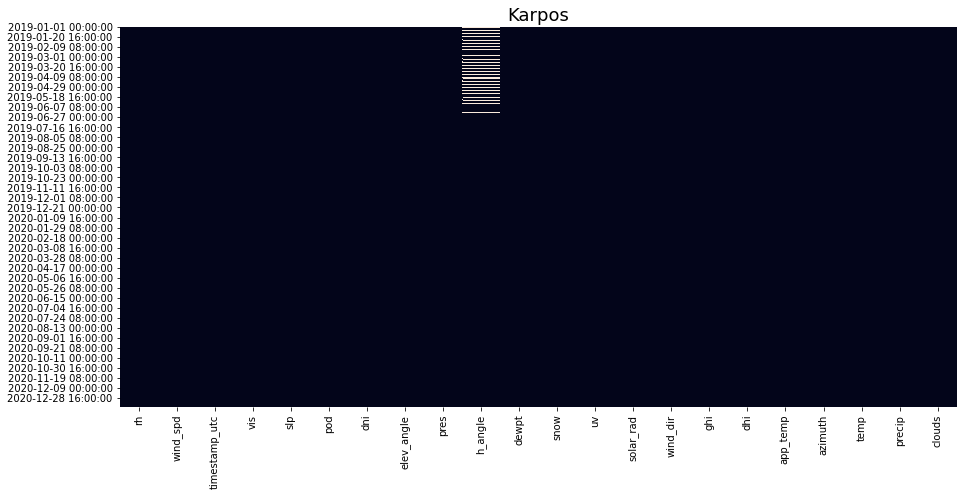

(17904, 22)
rh                 11
wind_spd            0
timestamp_utc       0
vis                 0
slp                11
pod                 0
dni                 0
elev_angle          0
pres               17
h_angle          1209
dewpt              11
snow               13
uv                  0
solar_rad           0
wind_dir           11
ghi                 0
dhi                 0
app_temp           13
azimuth             0
temp               13
precip              0
clouds              0
dtype: int64


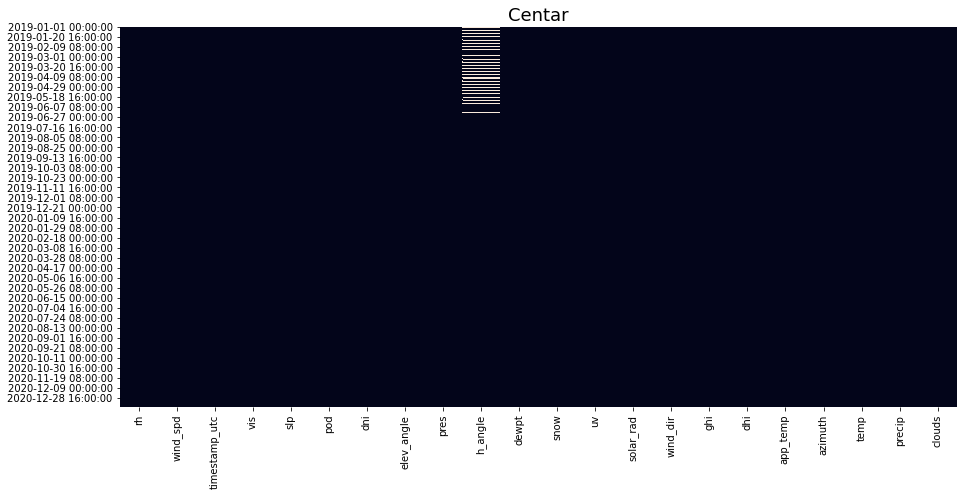

(17904, 22)
rh                  0
wind_spd            0
timestamp_utc       0
vis                 0
slp                 0
pod                 0
dni                 0
elev_angle          0
pres                0
h_angle          1184
dewpt               0
snow                0
uv                  0
solar_rad           0
wind_dir            0
ghi                 0
dhi                 0
app_temp            0
azimuth             0
temp                0
precip              0
clouds              0
dtype: int64


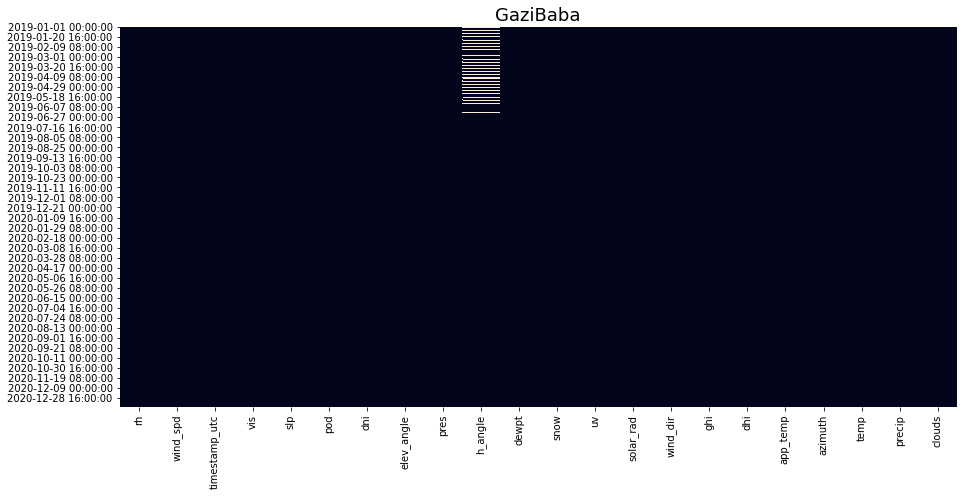

(17904, 22)
rh                  0
wind_spd            0
timestamp_utc       0
vis                 0
slp                 0
pod                 0
dni                 0
elev_angle          0
pres                0
h_angle          1184
dewpt               0
snow                0
uv                  0
solar_rad           0
wind_dir            0
ghi                 0
dhi                 0
app_temp            0
azimuth             0
temp                0
precip              0
clouds              0
dtype: int64


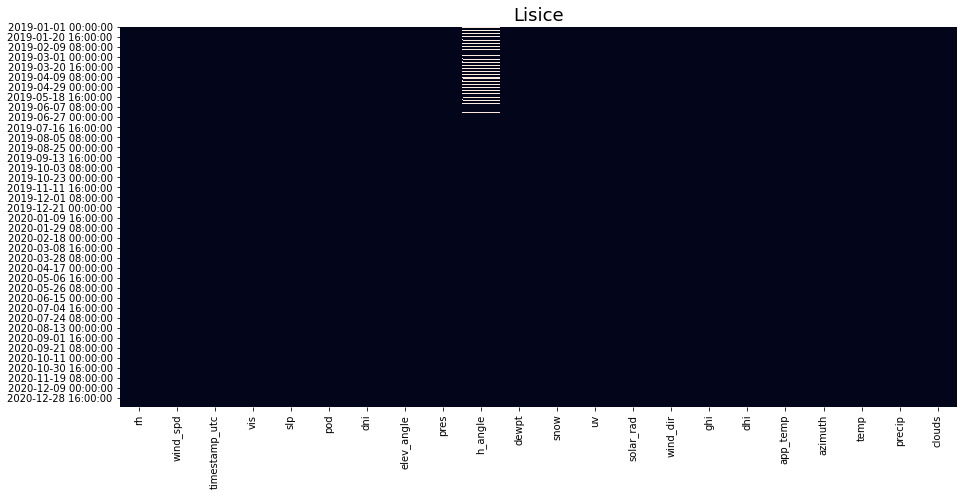

(17904, 22)
rh                  0
wind_spd            0
timestamp_utc       0
vis                 0
slp                 0
pod                 0
dni                 0
elev_angle          0
pres                0
h_angle          1184
dewpt               0
snow                0
uv                  0
solar_rad           0
wind_dir            0
ghi                 0
dhi                 0
app_temp            0
azimuth             0
temp                0
precip              0
clouds              0
dtype: int64


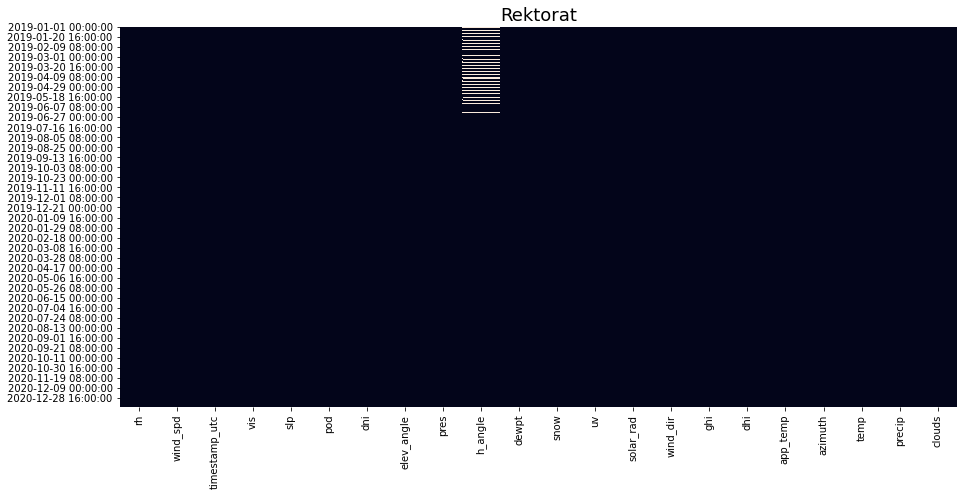

(17904, 22)
rh                  0
wind_spd            0
timestamp_utc       0
vis                 0
slp                 0
pod                 0
dni                 0
elev_angle          0
pres                0
h_angle          1184
dewpt               0
snow                0
uv                  0
solar_rad           0
wind_dir            0
ghi                 0
dhi                 0
app_temp            0
azimuth             0
temp                0
precip              0
clouds              0
dtype: int64


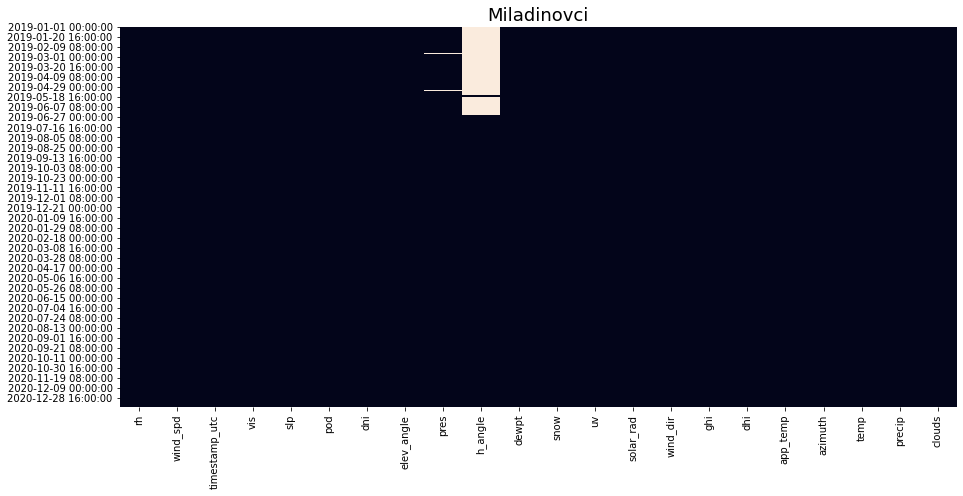

(17904, 22)
rh                  0
wind_spd            0
timestamp_utc       0
vis                 0
slp                 0
pod                 0
dni                 0
elev_angle          0
pres              145
h_angle          4063
dewpt               0
snow                0
uv                  0
solar_rad           0
wind_dir            1
ghi                 0
dhi                 0
app_temp            0
azimuth             0
temp                0
precip              0
clouds              0
dtype: int64


In [ ]:
for station in stations.keys():
  df = pd.read_csv(f'./weather_data/{station}.csv', index_col=0)
  plt.figure(figsize=(15, 7))
  sns.heatmap(df.isnull(), cbar=False).set_title(f'{station}', fontsize=18)
  plt.show()
  print(df.shape)
  print(df.isnull().sum(axis=0))

**Drop not needed data from weather datasets**

We dropped pod (part of the day) attribute because we already have information about the hour from the timestamp. Also, we discarded dhi (diffuse horizontal solar irradiance), dni (direct normal solar irradiance), ghi (global horizontal solar irradiance) and only included the solar radiation.  

In [ ]:
for station in stations.keys():
  df = pd.read_csv(f'./weather_data/{station}.csv', index_col=0)
  df.index.name = 'Timestamp'
  df = df.drop(['pod', 'dni', 'elev_angle', 'h_angle', 'ghi', 'dhi', 'azimuth', 'timestamp_utc'], axis=1)
  df.columns = ['relative_humidity', 'wind_speed', 'visibility', 'sea_level_pressure',
                'pressure', 'dew_point', 'snow', 'uv_index', 'solar_radiation',
                'wind_direction', 'apparent_temperature', 'temperature', 'precipitation', 'cloud_coverage']
  df.to_csv(f'./final_weather_data/{station}.csv', index=True)